In [16]:
#imports
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

In [17]:
#Function to create confusion matrices and calculate summary statistics
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
#the link above takes you to the page by Dennis T, creator of this function
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [18]:
#read the data, get shape and head
df=pd.read_csv('news/news.csv')
df.shape
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [19]:
#retrieve labels
labels=df.label
labels.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

In [20]:
#split data into training and testing sets
x_train, x_test, y_train, y_test=train_test_split(df['text'], labels, test_size=0.2, random_state=7)

In [21]:
#initialize TfidfVectorizer
#max_df of 0.7 ignores items that appear in more than 70% of samples
#stop_words are common words such as the, an, is, etc. that are to be filtered
tfidf_vectorizer=TfidfVectorizer (stop_words='english', max_df=0.7)

In [22]:
#fit and transform training set, transform testing set
tfidf_train=tfidf_vectorizer.fit_transform(x_train)
tfidf_test=tfidf_vectorizer.transform(x_test)

In [23]:
#logistic regression
logreg = LogisticRegression(random_state=0).fit(tfidf_train, y_train)
y_pred=logreg.predict(tfidf_test)
scorelogreg=accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(scorelogreg*100,2)}%')

Accuracy: 91.71%


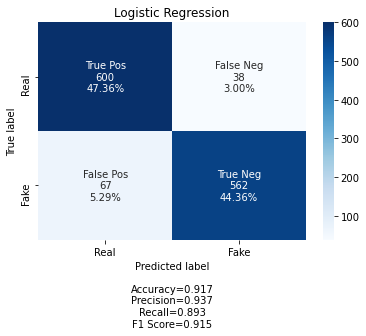

In [24]:
#logreg confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, labels=['FAKE','REAL'])
labelscfm = ['True Pos','False Neg','False Pos','True Neg']
categories = ['Real','Fake']
make_confusion_matrix(cf_matrix,
                      group_names=labelscfm,
                      categories=categories,
                      count=True,
                      sum_stats=True,
                      cmap='Blues',
                      title='Logistic Regression')

In [25]:
#Random Forest Classifier
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(tfidf_train, y_train)
y_pred=rfc.predict(tfidf_test)
scorerfc=accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(scorerfc*100,2)}%')

Accuracy: 75.85%


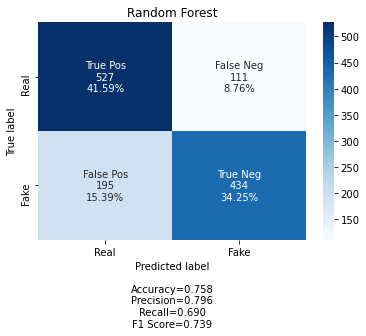

In [26]:
#random forest classifier confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
labelscfm = ['True Pos','False Neg','False Pos','True Neg']
categories = ['Real','Fake']
make_confusion_matrix(cf_matrix,
                      group_names=labelscfm,
                      categories=categories,
                      count=True,
                      cmap='Blues',
                      title='Random Forest')

In [27]:
#PassiveAggressiveClassifier
#PAC works by accepting input data in sequential order, and updating the model step-by-step as opposed to batch learning
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train)
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 92.98%


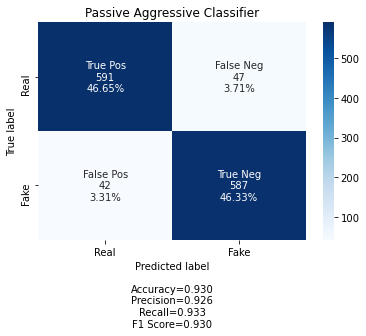

In [28]:
#pac confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
labelscfm = ['True Pos','False Neg','False Pos','True Neg']
categories = ['Real','Fake']
make_confusion_matrix(cf_matrix,
                      group_names=labelscfm,
                      categories=categories,
                      count=True,
                      cmap='Blues',
                      title='Passive Aggressive Classifier')